# Chinook Analysis — pandas + SQLAlchemy

This notebook loads the **Chinook** SQLite database into pandas DataFrames and performs basic analytics:
- Top 10 tracks by revenue
- Revenue by genre and by country
- Monthly revenue trend (YYYY–MM)

## Requirements
```
pip install pandas sqlalchemy matplotlib
```

In [1]:
!pip install sqlalchemy matplotlib

## Usage
1) Download `chinook.db` (SQLite).
2) Set the `CHINOOK_DB` path below and run the cells.

In [1]:
# Configure your Chinook DB path here
CHINOOK_DB = "./chinook.db"  # <-- CHANGE THIS

assert CHINOOK_DB and CHINOOK_DB.endswith(".db"), "Please set CHINOOK_DB to your chinook.db path"


In [6]:
# Imports
import pandas as pd
from sqlalchemy import create_engine, inspect, text
import matplotlib.pyplot as plt

# Create Engine
engine = create_engine(f"sqlite:///{CHINOOK_DB}", future=True)
print(f"sqlalchemy engine created >>> {engine}")

# Create Inspector
inspector = inspect(engine)

# List all tables
tables = inspector.get_table_names()
for index, table in enumerate(tables):
    print(f"{index+1}: {table}")

sqlalchemy engine created >>> Engine(sqlite:///./chinook.db)
1: albums
2: artists
3: customers
4: employees
5: genres
6: invoice_items
7: invoices
8: media_types
9: playlist_track
10: playlists
11: tracks


## Load core tables into DataFrames

In [8]:
def load_core_tables(engine):
    with engine.connect() as conn:
        tracks = pd.read_sql(text("SELECT * FROM tracks"), conn)
        invoice_items = pd.read_sql(text("SELECT * FROM invoice_items"), conn)
        invoices = pd.read_sql(text("SELECT * FROM invoices"), conn)
        customers = pd.read_sql(text("SELECT * FROM customers"), conn)
        albums = pd.read_sql(text("SELECT * FROM albums"), conn)
        artists = pd.read_sql(text("SELECT * FROM artists"), conn)
        genres = pd.read_sql(text("SELECT * FROM genres"), conn)

    return {
        "tracks": tracks,
        "invoice_items": invoice_items,
        "invoices": invoices,
        "customers": customers,
        "albums": albums,
        "artists": artists,
        "genres": genres,
    }

In [15]:
tables = load_core_tables(engine)

# 각 테이블 이름과 (행, 열) 형태 출력
print("\nTable Shapes:")
for name, df in tables.items():
    print(f"{name:15s}\t→\t{df.shape}")


Table Shapes:
tracks         	→	(3503, 9)
invoice_items  	→	(2240, 5)
invoices       	→	(412, 9)
customers      	→	(59, 13)
albums         	→	(347, 3)
artists        	→	(275, 2)
genres         	→	(25, 2)


In [16]:
# tracks 테이블의 마지막 5개 행 미리보기
print("\nTracks Table Sample:")
tables['tracks'].tail()


Tracks Table Sample:


TrackId                                               Name  AlbumId  \
3498     3499  Pini Di Roma (Pinien Von Rom) \ I Pini Della V...      343   
3499     3500  String Quartet No. 12 in C Minor, D. 703 "Quar...      344   
3500     3501               L'orfeo, Act 3, Sinfonia (Orchestra)      345   
3501     3502  Quintet for Horn, Violin, 2 Violas, and Cello ...      346   
3502     3503                                      Koyaanisqatsi      347   

      MediaTypeId  GenreId                 Composer  Milliseconds    Bytes  \
3498            2       24                     None        286741  4718950   
3499            2       24           Franz Schubert        139200  2283131   
3500            2       24       Claudio Monteverdi         66639  1189062   
3501            2       24  Wolfgang Amadeus Mozart        221331  3665114   
3502            2       10             Philip Glass        206005  3305164   

      UnitPrice  
3498       0.99  
3499       0.99  
3500       0.99  
3501       0.99  
3502       0.99

## Helper: Build a track dimension table (`track` + `album` + `artist` + `genre`)

In [ ]:
def build_dim_track(df: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Build a 'track dimension table' by joining multiple Chinook tables:
    tracks, albums, artists, and genres.

    Parameters
    ----------
    df : dict[str, pd.DataFrame]
        A dictionary containing DataFrames for each Chinook table,
        such as 'tracks', 'albums', 'artists', and 'genres'.

    Returns
    -------
    pd.DataFrame
        A new DataFrame containing track-level information
        enriched with album title, artist name, and genre name.
    """

    # Copy the original 'tracks' DataFrame to avoid modifying the input directly
    tracks = df["tracks"].copy()

    # Select relevant columns from 'albums' and rename 'Title' → 'AlbumTitle'
    albums = (
        df["albums"][["AlbumId", "Title", "ArtistId"]]
        .rename(columns={"Title": "AlbumTitle"})
    )

    # Rename the artist name column from 'Name' → 'ArtistName'
    artists = df["artists"].rename(columns={"Name": "ArtistName"})

    # Rename the genre name column from 'Name' → 'GenreName'
    genres = df["genres"].rename(columns={"Name": "GenreName"})

    # Merge all related information:
    #   1. tracks + albums  → adds album title and artist id
    #   2. + artists        → adds artist name
    #   3. + genres         → adds genre name
    dim_track = (
        tracks.merge(albums, on="AlbumId", how="left")
              .merge(artists, on="ArtistId", how="left")
              .merge(genres[["GenreId", "GenreName"]], on="GenreId", how="left")
    )

    return dim_track

In [37]:
# Build the dimension table
dim_track = build_dim_track(tables)

# Display the first few rows to verify the merge
dim_track.tail()

TrackId                                               Name  AlbumId  \
3498     3499  Pini Di Roma (Pinien Von Rom) \ I Pini Della V...      343   
3499     3500  String Quartet No. 12 in C Minor, D. 703 "Quar...      344   
3500     3501               L'orfeo, Act 3, Sinfonia (Orchestra)      345   
3501     3502  Quintet for Horn, Violin, 2 Violas, and Cello ...      346   
3502     3503                                      Koyaanisqatsi      347   

      MediaTypeId  GenreId                 Composer  Milliseconds    Bytes  \
3498            2       24                     None        286741  4718950   
3499            2       24           Franz Schubert        139200  2283131   
3500            2       24       Claudio Monteverdi         66639  1189062   
3501            2       24  Wolfgang Amadeus Mozart        221331  3665114   
3502            2       10             Philip Glass        206005  3305164   

      UnitPrice                                         AlbumTitle  ArtistId  \
3498       0.99                             Respighi:Pines of Rome       226   
3499       0.99  Schubert: The Late String Quartets & String Qu...       272   
3500       0.99                                Monteverdi: L'Orfeo       273   
3501       0.99                              Mozart: Chamber Music       274   
3502       0.99  Koyaanisqatsi (Soundtrack from the Motion Pict...       275   

                                             ArtistName   GenreName  
3498                                     Eugene Ormandy   Classical  
3499                             Emerson String Quartet   Classical  
3500  C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon...   Classical  
3501                                      Nash Ensemble   Classical  
3502                              Philip Glass Ensemble  Soundtrack

## Analysis: Top 10 Most in terms of Revenue

In [23]:
## Top 10 Tracks by Revenue

# 1. Copy relevant columns from the invoice_items table
invoice_items_df = tables["invoice_items"][["InvoiceId", "TrackId", "UnitPrice", "Quantity"]].copy()

# 2. Compute line-level revenue (price × quantity)
invoice_items_df["LineRevenue"] = invoice_items_df["UnitPrice"] * invoice_items_df["Quantity"]

# 3. Merge with track-related info (title, artist, album, genre)
track_sales_df = (
    invoice_items_df
    .merge(
        dim_track[["TrackId", "Name", "ArtistName", "AlbumTitle", "GenreName"]],
        on="TrackId",
        how="left"
    )
)
track_sales_df.head()

InvoiceId  TrackId  UnitPrice  Quantity  LineRevenue  \
0          1        2       0.99         1         0.99   
1          1        4       0.99         1         0.99   
2          2        6       0.99         1         0.99   
3          2        8       0.99         1         0.99   
4          2       10       0.99         1         0.99   

                    Name ArtistName                             AlbumTitle  \
0      Balls to the Wall     Accept                      Balls to the Wall   
1      Restless and Wild     Accept                      Restless and Wild   
2  Put The Finger On You      AC/DC  For Those About To Rock We Salute You   
3       Inject The Venom      AC/DC  For Those About To Rock We Salute You   
4             Evil Walks      AC/DC  For Those About To Rock We Salute You   

  GenreName  
0      Rock  
1      Rock  
2      Rock  
3      Rock  
4      Rock

## Revenue by genre

In [38]:
by_genre = (invoice_items_df.merge(dim_track[["TrackId","GenreName"]], on="TrackId", how="left")
              .groupby("GenreName", as_index=False)["LineRevenue"].sum()
              .sort_values("LineRevenue", ascending=False))
by_genre.head(10)

GenreName  LineRevenue
17                Rock       826.65
12               Latin       382.14
13               Metal       261.36
1   Alternative & Punk       241.56
22            TV Shows        93.53
11                Jazz        79.20
2                Blues        60.39
6                Drama        57.71
4            Classical        40.59
15            R&B/Soul        40.59

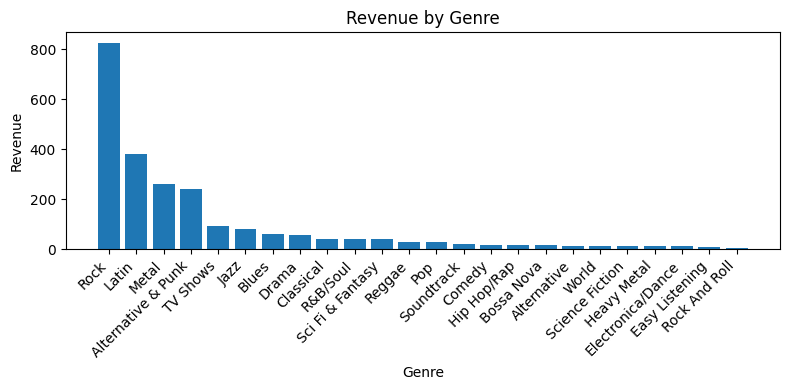

In [ ]:
# Visualize revenue by genre
plt.figure(figsize=(8,4))
plt.bar(
    x=by_genre["GenreName"],
    height=by_genre["LineRevenue"]
)
plt.title("Revenue by Genre")
plt.xlabel("Genre")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

---

## Revenue by country

In [47]:
## Revenue by Country

# 1. Select essential columns from the invoices table
#    Includes invoice ID, billing country, and invoice date.
invoices_df = tables["invoices"][["InvoiceId", "BillingCountry", "InvoiceDate"]].copy()

# 2. Select relevant columns from the invoice_items table
#    Each line item contains unit price and quantity for a given invoice.
invoice_items_df = tables["invoice_items"][["InvoiceId", "UnitPrice", "Quantity"]].copy()

# 3. Compute line-level revenue (UnitPrice × Quantity)
#    This gives the total sales amount for each individual item.
invoice_items_df["LineRevenue"] = invoice_items_df["UnitPrice"] * invoice_items_df["Quantity"]

# 4. Merge invoice header info (country, date) with line-level revenue
#    Use inner join on InvoiceId to align each invoice item with its country.
merged_sales_df = invoice_items_df.merge(invoices_df, on="InvoiceId", how="inner")

# 5. Group data by BillingCountry and sum up total revenue per country
#    Set as_index=False to keep 'BillingCountry' as a column rather than an index.
country_revenue_df = (
    merged_sales_df
    .groupby(by="BillingCountry", as_index=False)["LineRevenue"]
    .sum()
    .sort_values(by="LineRevenue", ascending=False)
)

# 6. Display the top 10 countries by revenue
country_revenue_df.head(10)


BillingCountry  LineRevenue
22             USA       523.06
5           Canada       303.96
10          France       195.10
4           Brazil       190.10
11         Germany       156.48
23  United Kingdom       112.86
7   Czech Republic        90.24
19        Portugal        77.24
13           India        75.26
6            Chile        46.62

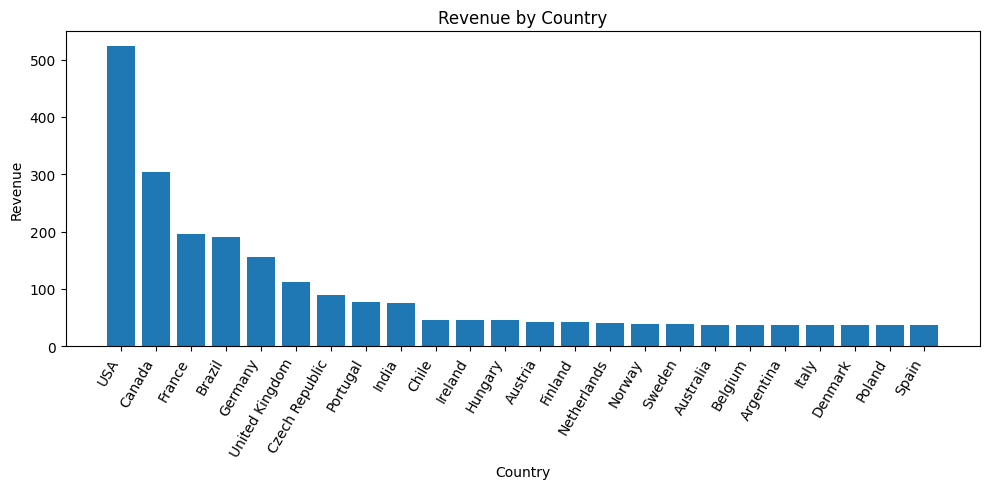

In [48]:
plt.figure(figsize=(10,5))
plt.bar(
    x=country_revenue_df["BillingCountry"],
    height=country_revenue_df["LineRevenue"]
)
plt.title("Revenue by Country")
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()